### [OPTIONAL] - Installing Packages on <img src="https://colab.google/static/images/icons/colab.png" width=100>

If you are viewing this notebook on Google Colab (or any other cloud vendor), you need to **uncomment and run** the following codeblock to install the dependencies for this chapter:

---

💡 **NOTE**: We will want to use a GPU to run the examples in this notebook. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

In [1]:
%%capture
!pip install --upgrade transformers sentence-transformers gensim scikit-learn accelerate peft scipy numpy


# Downloading and Running An LLM

The first step is to load our model onto the GPU for faster inference. Note that we load the model and tokenizer separately and keep them as such so that we can explore them separately.

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=False,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
prompt = "Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened.<|assistant|>"

# Tokenize the input prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

# Generate the text
generation_output = model.generate(
  input_ids=input_ids,
  max_new_tokens=20
)

# Print the output
print(tokenizer.decode(generation_output[0]))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Write an email apologizing to Sarah for the tragic gardening mishap. Explain how it happened.<|assistant|> Subject: Heartfelt Apologies for the Gardening Mishap


Dear


In [4]:
print(input_ids)

tensor([[14350,   385,  4876, 27746,  5281,   304, 19235,   363,   278, 25305,
           293, 16423,   292,   286,   728,   481, 29889, 12027,  7420,   920,
           372,  9559, 29889, 32001]], device='cuda:0')


In [5]:
for id in input_ids[0]:
   print(tokenizer.decode(id))

Write
an
email
apolog
izing
to
Sarah
for
the
trag
ic
garden
ing
m
ish
ap
.
Exp
lain
how
it
happened
.
<|assistant|>


In [6]:
generation_output

tensor([[14350,   385,  4876, 27746,  5281,   304, 19235,   363,   278, 25305,
           293, 16423,   292,   286,   728,   481, 29889, 12027,  7420,   920,
           372,  9559, 29889, 32001,  3323,   622, 29901, 17778, 29888,  2152,
          6225, 11763,   363,   278, 19906,   292,   341,   728,   481,    13,
            13,    13, 29928,   799]], device='cuda:0')

In [7]:
print(tokenizer.decode(3323))
print(tokenizer.decode(622))
print(tokenizer.decode([3323, 622]))
print(tokenizer.decode(29901))

Sub
ject
Subject
:


# Comparing Trained LLM Tokenizers


In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer

colors_list = [
    '102;194;165', '252;141;98', '141;160;203',
    '231;138;195', '166;216;84', '255;217;47'
]

def show_tokens(sentence, tokenizer_name):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    token_ids = tokenizer(sentence).input_ids
    for idx, t in enumerate(token_ids):
        print(
            f'\x1b[0;30;48;2;{colors_list[idx % len(colors_list)]}m' +
            tokenizer.decode(t) +
            '\x1b[0m',
            end=' '
        )

In [9]:
text = """
English and CAPITALIZATION
🎵 鸟
show_tokens False None elif == >= else: two tabs:"    " Three tabs: "       "
12.0*50=600
"""

In [10]:
show_tokens(text, "bert-base-uncased")

[CLS] english and capital ##ization [UNK] [UNK] show _ token ##s false none eli ##f = = > = else : two tab ##s : " " three tab ##s : " " 12 . 0 * 50 = 600 [SEP] 

In [11]:
show_tokens(text, "bert-base-cased")

[CLS] English and CA ##PI ##TA ##L ##I ##Z ##AT ##ION [UNK] [UNK] show _ token ##s F ##als ##e None el ##if = = > = else : two ta ##bs : " " Three ta ##bs : " " 12 . 0 * 50 = 600 [SEP] 

In [12]:
show_tokens(text, "gpt2")


 English  and  CAP ITAL IZ ATION 
 � � �  � � � 
 show _ t ok ens  False  None  el if  ==  >=  else :  two  tabs :"        "  Three  tabs :  "              " 
 12 . 0 * 50 = 600 
 

In [13]:
show_tokens(text, "google/flan-t5-small")

English and CA PI TAL IZ ATION  <unk>  <unk> show _ to ken s Fal s e None  e l if = = > = else : two tab s : " " Three tab s : " " 12. 0 * 50 = 600  </s> 

In [14]:
# The official is `tiktoken` but this the same tokenizer on the HF platform
show_tokens(text, "Xenova/gpt-4")


 English  and  CAPITAL IZATION 
 � � �  � � � 
 show _tokens  False  None  elif  ==  >=  else :  two  tabs :"      "  Three  tabs :  "         "
 12 . 0 * 50 = 600 
 

In [15]:
# You need to request access before being able to use this tokenizer
show_tokens(text, "bigcode/starcoder2-15b")


 English  and  CAPITAL IZATION 
 � � �   � � 
 show _ tokens  False  None  elif  ==  >=  else :  two  tabs :"      "  Three  tabs :  "         " 
 1 2 . 0 * 5 0 = 6 0 0 
 

In [16]:
show_tokens(text, "facebook/galactica-1.3b")


 English  and  CAP ITAL IZATION 
 � � � �  � � � 
 show _ tokens  False  None  elif   ==   > =  else :  two  t abs : "      "  Three  t abs :   "         " 
 1 2 . 0 * 5 0 = 6 0 0 
 

In [17]:
show_tokens(text, "microsoft/Phi-3-mini-4k-instruct")

 
 English and C AP IT AL IZ ATION 
 � � � �  � � � 
 show _ to kens False None elif == >= else : two tabs :"    " Three tabs : "       " 
 1 2 . 0 * 5 0 = 6 0 0 
 

# Contextualized Word Embeddings From a Language Model (Like BERT)

In [18]:
from transformers import AutoModel, AutoTokenizer

# Load a tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

# Load a language model
model = AutoModel.from_pretrained("microsoft/deberta-v3-xsmall")

# Tokenize the sentence
tokens = tokenizer('Hello world', return_tensors='pt')

# Process the tokens
output = model(**tokens)[0]

In [19]:
output.shape

torch.Size([1, 4, 384])

In [20]:
for token in tokens['input_ids'][0]:
    print(tokenizer.decode(token))

[CLS]
Hello
 world
[SEP]


In [21]:
output

tensor([[[-3.4816,  0.0861, -0.1819,  ..., -0.0612, -0.3911,  0.3017],
         [ 0.1898,  0.3208, -0.2315,  ...,  0.3714,  0.2478,  0.8048],
         [ 0.2071,  0.5036, -0.0485,  ...,  1.2175, -0.2292,  0.8582],
         [-3.4278,  0.0645, -0.1427,  ...,  0.0658, -0.4367,  0.3834]]],
       grad_fn=<NativeLayerNormBackward0>)

# Text Embeddings (For Sentences and Whole Documents)

In [22]:
from sentence_transformers import SentenceTransformer

# Load model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Convert text to text embeddings
vector = model.encode("Best movie ever!")

In [23]:
vector.shape

(768,)

# Word Embeddings Beyond LLMs


In [24]:
import gensim.downloader as api

# Download embeddings (66MB, glove, trained on wikipedia, vector size: 50)
# Other options include "word2vec-google-news-300"
# More options at https://github.com/RaRe-Technologies/gensim-data
model = api.load("glove-wiki-gigaword-50")

In [25]:
model.most_similar([model['king']], topn=11)

[('king', 1.0000001192092896),
 ('prince', 0.8236179351806641),
 ('queen', 0.7839043140411377),
 ('ii', 0.7746230363845825),
 ('emperor', 0.7736247777938843),
 ('son', 0.766719400882721),
 ('uncle', 0.7627150416374207),
 ('kingdom', 0.7542161345481873),
 ('throne', 0.7539914846420288),
 ('brother', 0.7492411136627197),
 ('ruler', 0.7434253692626953)]

# Recommending songs by embeddings

In [26]:
model.most_similar([model['king']], topn=11)

[('king', 1.0000001192092896),
 ('prince', 0.8236179351806641),
 ('queen', 0.7839043140411377),
 ('ii', 0.7746230363845825),
 ('emperor', 0.7736247777938843),
 ('son', 0.766719400882721),
 ('uncle', 0.7627150416374207),
 ('kingdom', 0.7542161345481873),
 ('throne', 0.7539914846420288),
 ('brother', 0.7492411136627197),
 ('ruler', 0.7434253692626953)]

In [27]:
import pandas as pd
from urllib import request

# Get the playlist dataset file
data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')

# Parse the playlist dataset file. Skip the first two lines as
# they only contain metadata
lines = data.read().decode("utf-8").split('\n')[2:]

# Remove playlists with only one song
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]

# Load song metadata
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')
songs_file = songs_file.read().decode("utf-8").split('\n')
songs = [s.rstrip().split('\t') for s in songs_file]
songs_df = pd.DataFrame(data=songs, columns = ['id', 'title', 'artist'])
songs_df = songs_df.set_index('id')

In [28]:
print( 'Playlist #1:\n ', playlists[0], '\n')
print( 'Playlist #2:\n ', playlists[1])

Playlist #1:
  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43'] 

Playlist #2:
  ['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '104', '105', '106', '107', '47', '108', '109', '110', '111', '112', '113', '25', '63', '62', '114', '115', '84', '116', '117',

In [29]:
from gensim.models import Word2Vec

# Train our Word2Vec model
model = Word2Vec(
    playlists, vector_size=32, window=20, negative=50, min_count=1, workers=4
)

In [30]:
song_id = 2172

# Ask the model for songs similar to song #2172
model.wv.most_similar(positive=str(song_id))

[('2849', 0.9980509281158447),
 ('5634', 0.9963890314102173),
 ('1922', 0.9958516359329224),
 ('11473', 0.9958326816558838),
 ('5586', 0.9957252740859985),
 ('6658', 0.9954787492752075),
 ('5549', 0.9952214956283569),
 ('3117', 0.9950847625732422),
 ('2014', 0.9948998689651489),
 ('2704', 0.9947589635848999)]

In [31]:
print(songs_df.iloc[2172])

title     Fade To Black
artist        Metallica
Name: 2172 , dtype: object


In [32]:
import numpy as np

def print_recommendations(song_id):
    similar_songs = np.array(
        model.wv.most_similar(positive=str(song_id),topn=5)
    )[:,0]
    return  songs_df.iloc[similar_songs]

# Extract recommendations
print_recommendations(2172)

,title,artist
id,,
2849,Run To The Hills,Iron Maiden
5634,Mr. Brownstone,Guns N' Roses
1922,One,Metallica
11473,Little Guitars,Van Halen
5586,The Last In Line,Dio


In [33]:
print_recommendations(2172)

,title,artist
id,,
2849,Run To The Hills,Iron Maiden
5634,Mr. Brownstone,Guns N' Roses
1922,One,Metallica
11473,Little Guitars,Van Halen
5586,The Last In Line,Dio


In [34]:
print_recommendations(842)

,title,artist
id,,
886,Heartless,Kanye West
413,If I Ruled The World (Imagine That) (w\/ Laury...,Nas
12205,Give It Up To Me,Sean Paul
5661,Sweet Dreams,Beyonce
196,I'll Be Missing You,Puff Daddy & The Family


## 🧠 Token-Based Product Recommender

This notebook demonstrates how to use token embeddings from a pre-trained transformer (e.g. BERT) to recommend products similar to a user’s query based on text similarity.


In [35]:
!pip install -U matplotlib

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [36]:
# Load a pretrained tokenizer and model
model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id)


In [37]:
# Example list of products
products = [
    "red running shoes",
    "leather handbag",
    "white sneakers",
    "blue denim jacket",
    "black formal shoes"
]

In [38]:
# Function to get embedding by averaging last hidden state
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


In [39]:
# Create embeddings for all products
product_embeddings = [get_embedding(p) for p in products]


In [40]:
# Example user query
query = "sporty footwear"
query_embedding = get_embedding(query)

In [41]:
# Compute cosine similarity
similarities = cosine_similarity([query_embedding], product_embeddings)[0]
top_n = 3
top_indices = np.argsort(similarities)[::-1][:top_n]


In [42]:
print("User Query:", query)
print("\nTop Recommendations:")
for i in top_indices:
    print(f"{products[i]} (Score: {similarities[i]:.2f})")


User Query: sporty footwear

Top Recommendations:
black formal shoes (Score: 0.77)
leather handbag (Score: 0.75)
red running shoes (Score: 0.74)


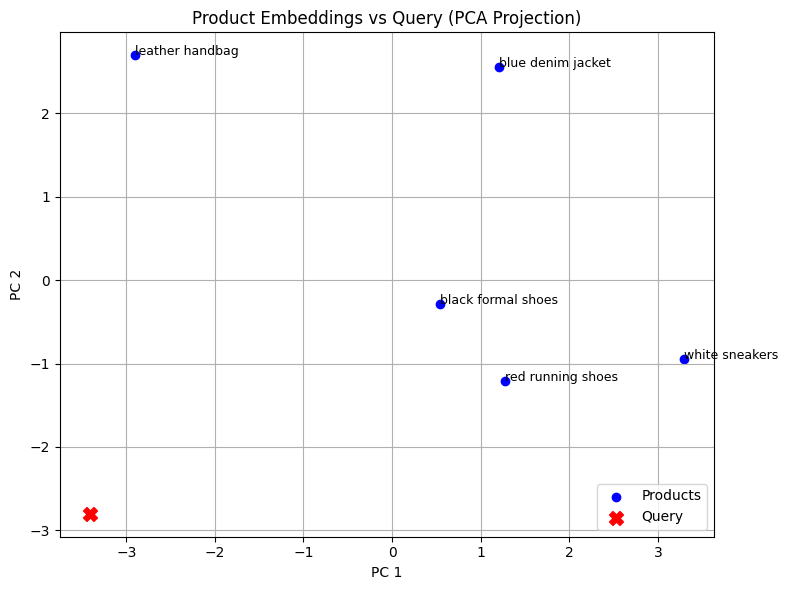

In [43]:
# Visualization with PCA
all_embeddings = np.vstack([query_embedding] + product_embeddings)
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[1:, 0], reduced[1:, 1], label="Products", c="blue")
plt.scatter(reduced[0, 0], reduced[0, 1], label="Query", c="red", marker="X", s=100)

for i, txt in enumerate(products):
    plt.annotate(txt, (reduced[i+1, 0], reduced[i+1, 1]), fontsize=9)

plt.title("Product Embeddings vs Query (PCA Projection)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()